# **Distributed Training On NVIDIA DGX Station A100**

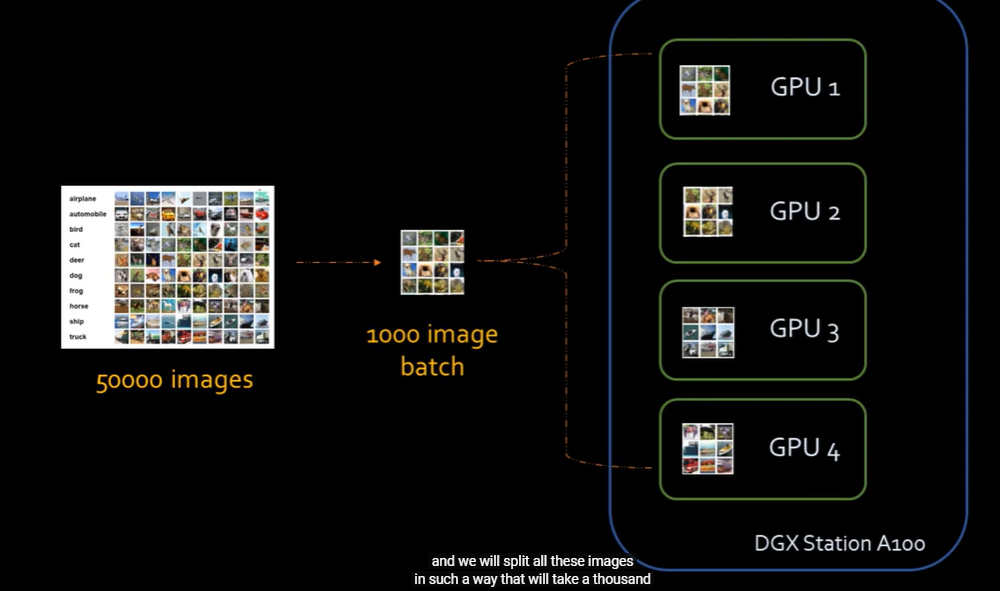

# Small Image Classification Using Simple Aritifical Neural Network: GPU Benchmarking

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
# Version Information
# tensorflow 2.2.0 , Cudnn7.6.5 and Cuda 10.1 , python 3.8

This command shows list of physical devices available for tensorflow. You can see GPU listed here. If you have NVIDIA GPU you need to install CUDA toolkit and cuDNN as per instruction on this webpage. Without proper installation you will not see GPU in list of devices

https://shawnhymel.com/1961/how-to-install-tensorflow-with-gpu-support-on-windows/

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
tf.__version__

'2.17.1'

In [5]:
tf.test.is_built_with_cuda()

True

# Load the dataset

Our dataset contains 60000 small training images that belongs to one of the below 10 classes

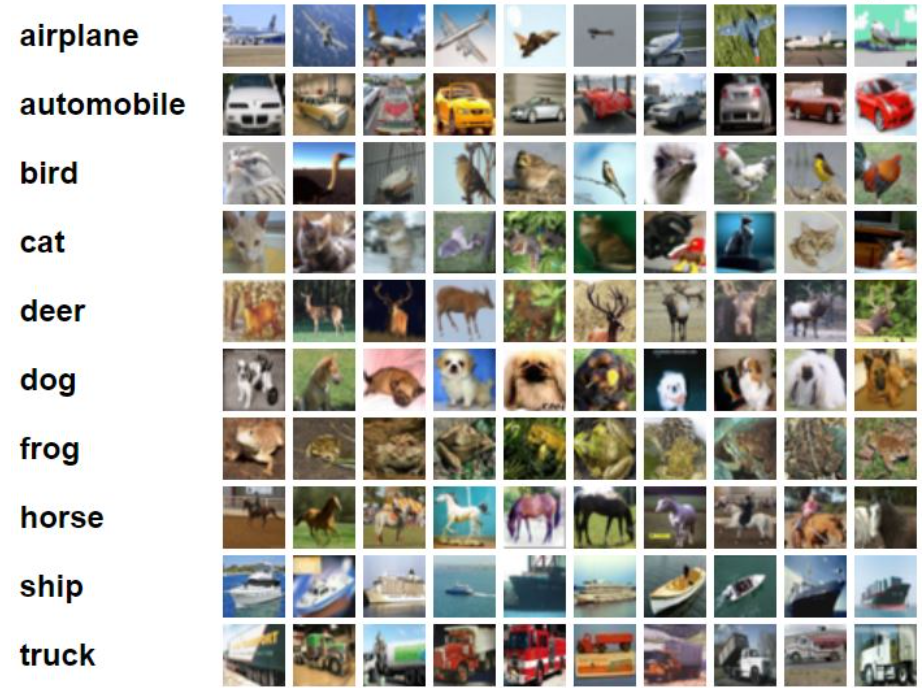

In [9]:
(X_train, y_train), (X_test,y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [10]:
X_train.shape

(50000, 32, 32, 3)

In [11]:
y_train.shape

(50000, 1)

In [9]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [10]:
classes[y_train[3][0]]

'deer'

In [11]:
y_train[:3]

array([[6],
       [9],
       [9]], dtype=uint8)

In [12]:
y_test.shape

(10000, 1)

In [13]:
X_train.shape

(50000, 32, 32, 3)

# Preprocessing: Scale images

In [12]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [15]:
y_train_categorical = keras.utils.to_categorical(y_train, num_classes=10)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes=10)

In [19]:
y_train[0:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [16]:
y_train_categorical[0:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Model building and training

In [20]:
def get_model():
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(32,32,3)),
            keras.layers.Dense(3000, activation='relu'),
            keras.layers.Dense(1000, activation='relu'),
            keras.layers.Dense(10, activation='sigmoid')
        ])

    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [17]:
train_tf_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_categorical))
test_tf_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_categorical))

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
strategy.num_replicas_in_sync

1

In [18]:
BATCH_SIZE_PER_REPLICA = 250
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync


train_dataset = train_tf_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_tf_dataset.batch(BATCH_SIZE)

In [21]:
%%timeit -n1 -r1
with strategy.scope():
    gpu_model = get_model()
    gpu_model.fit(train_dataset, epochs=50)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 67s 327ms/step - accuracy: 0.2437 - loss: 2.1007
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 334ms/step - accuracy: 0.3544 - loss: 1.8350
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 344ms/step - accuracy: 0.3867 - loss: 1.7625
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 71s 343ms/step - accuracy: 0.4030 - loss: 1.7138
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 340ms/step - accuracy: 0.4161 - loss: 1.6765
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 67s 332ms/step - accuracy: 0.4262 - loss: 1.6455
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 324ms/step - accuracy: 0.4367 - loss: 1.6188
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 324ms/step - accuracy: 0.4456 - loss: 1.5955
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 331ms/step - accuracy: 0.4533 - loss: 1.5748
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 67s 328ms/step - accuracy: 0.4593 - loss: 1.5562
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 368ms/step - accuracy: 0.4645 - loss: 1.5391
Epoch 12/50
200/200

# Measure training time on a CPU

In [22]:
%%timeit -n1 -r1
with tf.device('/CPU:0'):
    cpu_model = get_model()
    cpu_model.fit(train_dataset, epochs=50)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 72s 348ms/step - accuracy: 0.2507 - loss: 2.0903
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 348ms/step - accuracy: 0.3598 - loss: 1.8326
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 71s 357ms/step - accuracy: 0.3859 - loss: 1.7631
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 347ms/step - accuracy: 0.4022 - loss: 1.7174
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 348ms/step - accuracy: 0.4146 - loss: 1.6814
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 346ms/step - accuracy: 0.4249 - loss: 1.6512
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 352ms/step - accuracy: 0.4342 - loss: 1.6248
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 343ms/step - accuracy: 0.4418 - loss: 1.6013
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 380ms/step - accuracy: 0.4495 - loss: 1.5803
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 347ms/step - accuracy: 0.4564 - loss: 1.5612
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 354ms/step - accuracy: 0.4631 - loss: 1.5438
Epoch 12/50
200/200

# **Tensorflow Input Pipeline | tf Dataset**